In [1]:
#get 10 files, each is the same timestep for a member of a
#10 member ensemble
data_download=False
if data_download:
    root='http://clouds.eos.ubc.ca/~phil/docs/atsc500/dryles'
    for i in np.arange(1,11,dtype=np.int):
        the_name='mar12014_{:d}_15600.nc'.format(i)
        print(the_name)
        url='{}/{}'.format(root,the_name)
        urllib.request.urlretrieve(url,the_name)
           

In [2]:
import glob
import xray
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple
import textwrap

def sort_name(name):
    """
      sort the filenames so '10' sorts
      last by converting to integers
    """
    front, number, back = name.split('_')
    return int(number)


def dict_to_nt(the_dict, tupname):
    """
      convert a dictionary into a namedtuple
    """
    # first define the keys as attributes
    In_tup = namedtuple(tupname, the_dict.keys())
    # then read the key,value pairs in and assign to
    # attributes
    out_tuple = In_tup(**the_dict)
    return out_tuple

def theta(p, T):
    """
      input: p (Pa), scalar pressure
             T (K),  scalar or array of temperatures
      output: thetaval (K) potential temperature
    """
    Rd = 287  # dry air gas constant  J/kg/K
    cp = 1004.  # dry air heat capacity at constant pressure (J/kg/K)
    p0 = 1.e5  # reference pressure (Pa)
    the_exp = Rd / cp
    thetaval = T * (p0 / p)**the_exp
    return thetaval

In [6]:
the_files = glob.glob('mar*nc')
the_files.sort(key=sort_name)

#
#  put the 10 ensembles together along a new "ens" dimension
#  using an xray multi-file dataset
#
#  Checkpointing
#
#  This is slow, so only do it once, and store the variables
#  using np.savez.   Then set firstrun=False and read the 
#  variables out of the npz file instead of recalculating
#
#  Store the variables in a namedtuple so we don't have to continually
#  be typing in dictionary indices  (too many keystrokes)
#
#
firstrun = True
if firstrun:
    ds = xray.open_mfdataset(the_files, engine='netcdf4', concat_dim='ens')
    # dump the structure
    print(ds)
    #
    #  3-d ensemble average for temp
    #
    x = ds['x']
    y = ds['y']
    z = ds['z']
    temp = ds['TABS']
    mean_temp = temp[:, 0, :, :, :].mean(dim='ens')
    #
    # same for velocity
    #
    vvel = ds['V']
    uvel = ds['U']
    wvel = ds['W']
    mean_v = vvel[:, 0, :, :, :].mean(dim='ens')
    mean_u = uvel[:, 0, :, :, :].mean(dim='ens')
    mean_w = wvel[:, 0, :, :, :].mean(dim='ens')
    # pressure
    p = ds['p']
    pp = ds['PP']
    #print(p.shape)
    mean_p = p[:,:].mean(dim='ens')

    
    mean_temps_spacial = mean_temp.mean(dim='x').mean(dim='y')

    #print(mean_temp.shape)
    
    theta_mean=[]
    
    for i in range(0, mean_p.shape[0]):
        theta_mean.append(theta(mean_p[i]*100, mean_temps_spacial[i]))
      
    theta_mean = np.array(theta_mean)
    #
    # now look at the perturbation fields for one ensemble
    #
    vvelprime = vvel[0, 0, :, :, :] - mean_v
    uvelprime = uvel[0, 0, :, :, :] - mean_u
    wvelprime = wvel[0, 0, :, : ,:] - mean_w
    pprime = p[0,:] - mean_p
    
    theta_prime=[]
    temps = temp[0,0,:,:,:].mean(axis=2).mean(axis=1)
    for i in range(0, mean_p.shape[0]):
        theta_prime.append(theta(mean_p[i]*100, temps[i]) - theta_mean[i])
        
    theta_prime = np.array(theta_prime)
        
    Tprime = temp[0, 0, :, :, :] - mean_temp
    
    vflux_prime = vvelprime * Tprime
    uflux_prime = uvelprime * Tprime
    wflux_prime = wvelprime * Tprime
    
    uw_var = uvelprime*wvelprime
    uw_profile = uw_var.mean(dim='x').mean(dim='y')
    
    wflux_profile = wflux_prime.mean(dim='x').mean(dim='y')
    
    keep_dict = dict(flux_prof=wflux_profile, flux_prime=wflux_prime.values,
                     wvelprime=wvelprime.values, uvelprime=uvelprime.values, vvelprime=vvelprime.values,
                     Tprime=Tprime.values, pprime=pprime.values, uw_profile=uw_profile.values, mean_temp=mean_temp,
                     mean_p=mean_p, theta_mean=theta_mean, theta_prime=theta_prime, pp=pp, x=x, y=y, z=z)
    
    np.savez('tke.npz', **keep_dict)
    var_tup = dict_to_nt(keep_dict, 'vars')
else:
    in_dict = np.load('tke.npz')
    var_tup = dict_to_nt(in_dict, 'vars')
    print(var_tup._fields)
    vvelprime = var_tup.vvelprime
    uvelprime = var_tup.uvelprime
    wvelprime = var_tup.wvelprime
    pprime = var_tup.pprime
    ds = xray.open_mfdataset(the_files, engine='netcdf4', concat_dim='ens')
    # dump the structure
    print(ds)

<xray.Dataset>
Dimensions:  (ens: 10, time: 1, x: 192, y: 128, z: 312)
Coordinates:
  * x        (x) float32 0.0 25.0 50.0 75.0 100.0 125.0 150.0 175.0 200.0 ...
  * y        (y) float32 0.0 25.0 50.0 75.0 100.0 125.0 150.0 175.0 200.0 ...
  * z        (z) float32 25.0 50.0 75.0 100.0 125.0 150.0 175.0 200.0 205.0 ...
  * time     (time) float32 169.181
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    p        (ens, z) float32 997.193 994.391 991.594 988.803 986.017 ...
    TABS     (ens, time, z, y, x) float32 303.934 304.035 303.998 303.829 ...
    QV       (ens, time, z, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    PP       (ens, time, z, y, x) float32 0.288351 0.314277 0.301808 ...
    U        (ens, time, z, y, x) float32 0.488386 0.450059 0.29529 0.261922 ...
    V        (ens, time, z, y, x) float32 -0.241863 -0.194893 -0.189609 ...
    W        (ens, time, z, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


zi = 490.0 m 


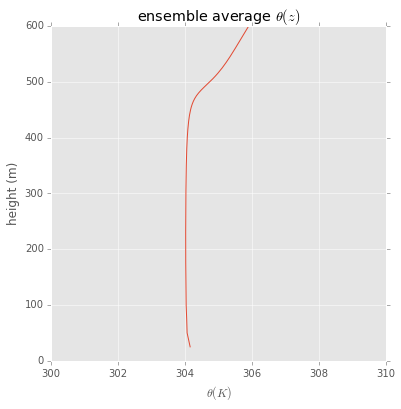

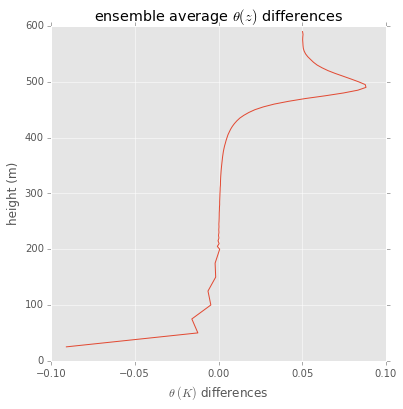

In [8]:
%matplotlib inline
plt.style.use('ggplot')

# find z_i
temps = var_tup.mean_temp
pressures = var_tup.mean_p*100 # convert to Pa
#thetas = np.empty_like(temps)

#for i in range(0, pressures.shape[0]):
    #thetas[i] = theta(pressures[i], temps[i])

#theta_means = thetas.mean(axis=2).mean(axis=1)
heights = var_tup.z
fig, ax = plt.subplots(1, 1,figsize=(6,6))
theta_mean = var_tup.theta_mean
ax.plot(var_tup.theta_mean,heights)
ax.set(ylim=(0, 600), xlim=(300, 310))
out=ax.set(title=r'ensemble average $\theta(z)$',xlabel=r'$\theta (K)$',
       ylabel='height (m)')

# plot differences profile; find greatest difference
fig, ax = plt.subplots(1, 1,figsize=(6,6))
height_index = np.where(heights==600)[0]
ax.plot(np.diff(theta_mean[0:height_index]), heights[0:height_index-1])
#ax.set(ylim=(0, 600), xlim=(300, 310))
out=ax.set(title=r'ensemble average $\theta(z)$ differences',xlabel=r'$\theta\ (K)$ differences',
       ylabel='height (m)')

zi_ind = np.where(np.diff(theta_mean[0:height_index]) == max(np.diff(theta_mean[0:height_index])))[0][0]
zi = np.array(heights)[zi_ind]
print('zi = {} m '.format(zi))

In [54]:
# define all perturbation/flux terms
TKE = 0.5*((var_tup.vvelprime**2).mean(axis=2).mean(axis=1) + (var_tup.uvelprime**2).mean(axis=2).mean(axis=1)
           + (var_tup.wvelprime**2).mean(axis=2).mean(axis=1))

horizontal_var = (var_tup.vvelprime**2).mean(axis=2).mean(axis=1) + (var_tup.uvelprime**2).mean(axis=2).mean(axis=1)

TKE_flux = np.empty_like(var_tup.wvelprime)
horiz_flux = np.empty_like(var_tup.wvelprime)
for i in range(0, TKE.shape[0]):
    TKE_flux[i,:,:] = var_tup.wvelprime[i,:,:]*TKE[i]
    horiz_flux[i,:,:] = var_tup.wvelprime[i,:,:]*horizontal_var[i]

TKE_flux_prof = TKE_flux.mean(axis=2).mean(axis=1)
horiz_flux_prof = horiz_flux.mean(axis=2).mean(axis=1)

theta_primes = np.empty_like(var_tup.Tprime.mean(axis=2).mean(axis=1))


#Tprimes = var_tup.Tprime.mean(axis=2).mean(axis=1)
#for i in range(0, pressures.shape[0]):
    #theta_primes[i] = theta(pressures[i], Tprimes[i])

theta_prime = var_tup.theta_prime
g = 9.81 # m/s^2

theta_flux = np.empty_like(var_tup.wvelprime)

for i in range(0, wvelprime.shape[0]):
    theta_flux[i,:,:] = var_tup.wvelprime[i,:,:]*theta_prime[i]

    
w_star = ((g*zi/theta_mean)*(theta_flux.mean(axis=2).mean(axis=1)))**(1./3)
u_star = (var_tup.uvelprime*var_tup.wvelprime).mean(axis=2).mean(axis=1)/w_star
k = 0.4
zeta = (-k*heights*g*theta_flux.mean(axis=2).mean(axis=1))/(theta_mean*u_star**3)
press_var = (((var_tup.pp[:,0,:,:,:].mean(axis=0))**2)).mean(axis=2).mean(axis=1)


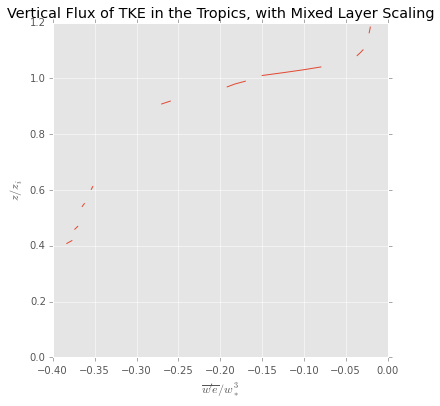

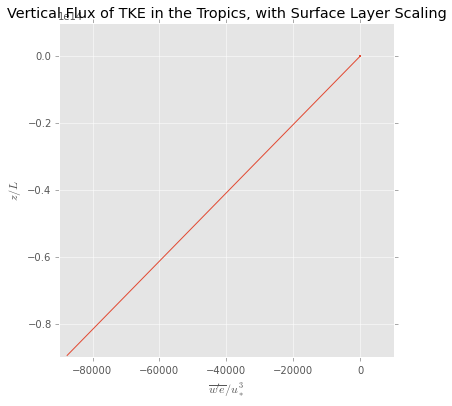

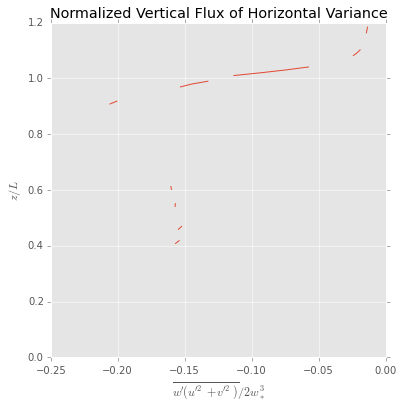

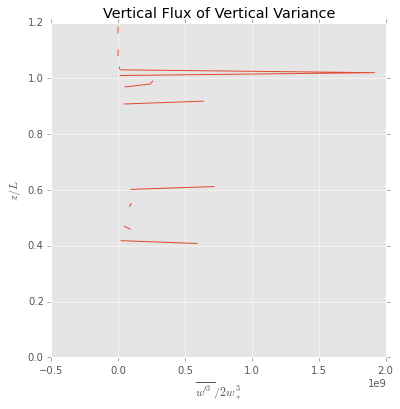

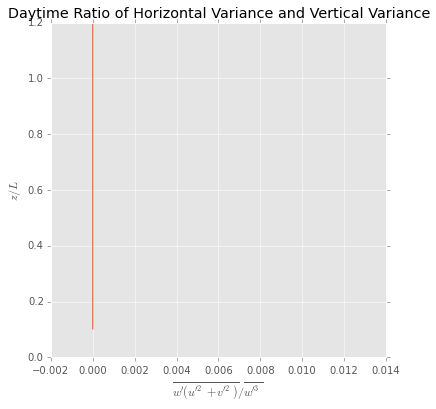

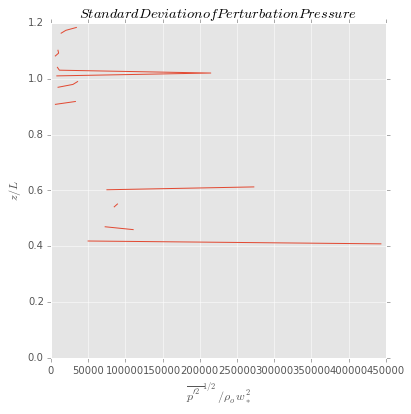

In [74]:
# now make plots
# fig 5.9a
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(TKE_flux_prof/w_star**3, heights/zi)
ax.set(ylim=(0, 1.2))
out=ax.set(title=r'Vertical Flux of TKE in the Tropics, with Mixed Layer Scaling',
           xlabel=r"$\overline{w'e}/w^3_*$", ylabel=r'$z/z_i$')

# fig 5.9b
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(TKE_flux_prof/u_star**3, zeta)
#ax.set(ylim=(0, 1.2))
out=ax.set(title=r'Vertical Flux of TKE in the Tropics, with Surface Layer Scaling',
           xlabel=r"$\overline{w'e}/u^3_*$", ylabel=r'$z/L$')

# fig 5.10a
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(horiz_flux_prof/(2*w_star**3), heights/zi)
ax.set(ylim=(0, 1.2))
out=ax.set(title=r'Normalized Vertical Flux of Horizontal Variance',
           xlabel=r"$\overline{w'(u'^2 + v'^2)}/2w^3_*$", ylabel=r'$z/L$')

# fig 5.10b
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot((wvelprime**3).mean(axis=2).mean(axis=1)/(2*w_star**3), heights/zi)
ax.set(ylim=(0, 1.2))
out=ax.set(title=r'Vertical Flux of Vertical Variance',
           xlabel=r"$\overline{w'^3}/2w^3_*$", ylabel=r'$z/L$')

# fig 5.10c
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(horiz_flux_prof/(wvelprime**3).mean(axis=2).mean(axis=1), heights/zi)
ax.set(ylim=(0, 1.2))
out=ax.set(title=r'Daytime Ratio of Horizontal Variance and Vertical Variance',
           xlabel=r"$\overline{w'(u'^2 + v'^2)}/\overline{w'^3}$", ylabel=r'$z/L$')

# 5.12
fig, ax = plt.subplots(1,1, figsize=(6,6))
rho = 1.2 
ax.plot(press_var/(rho*w_star**2), heights/zi)
ax.set(ylim=(0, 1.2))
out=ax.set(title=r"$Standard Deviation of Perturbation Pressure$",
           xlabel=r"$\overline{p'^2}^{1/2}/\rho_ow^2_*$", ylabel=r'$z/L$')